<h1>Home Assignment #1</h1>


## Task 1. PCA implementation (1 point)

In this task, you are required to create your own class for PCA, implementing methods `fit` and `transform`. Class should require `n_components` parameter in the constructor.

In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler

class PCA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.std_scaler = StandardScaler()
        self.mean_vector = None
        self.projection_matrix = None
        self.eigen_pairs = None
        self.explained_variance = None
        self.n_features = None

    def fit(self, X, y=None):
        self.n_features = X.shape[1]
        self.std_scaler.fit(X)
        X_std = self.std_scaler.transform(X)
        self.mean_vector = np.mean(X_std, axis=0)
        X_std -= self.mean_vector
        u, s, vt = np.linalg.svd(X_std.T, full_matrices=False)
        eigen_pairs = [(s[i], -u[:, i]) for i in range(X.shape[1])]
        eigen_pairs.sort(key=lambda x: x[0], reverse=True)
        self.eigen_pairs = eigen_pairs
        total_variance = sum(s**2)
        self.explained_variance = [eigen_pairs[i][0]**2 / total_variance for i in range(X.shape[1])]
        self.projection_matrix = np.hstack(
            [eigen_pairs[i][1].reshape(X.shape[1], 1) for i in range(self.n_components)]
        )

    def set_n_components(self, n_components):
        self.n_components = n_components
        self.projection_matrix = np.hstack(
            [self.eigen_pairs[i][1].reshape(self.n_features, 1) for i in range(self.n_components)]
        )

    def transform(self, X, y=None):
        X_std = self.std_scaler.transform(X)
        X_std -= self.mean_vector
        return X_std.dot(self.projection_matrix)

    def inverse_transform(self, X, y=None):
        inv_std = X.dot(self.projection_matrix.T) + self.mean_vector
        return self.std_scaler.inverse_transform(inv_std)

Now, create some dataset using `sklearn` and implement fit and transform of your class at created data.

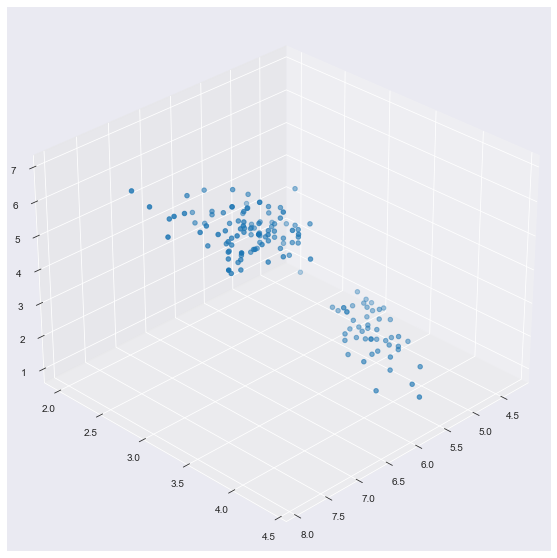

In [3]:
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt

X, _ = load_iris(return_X_y=True)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d', azim=45, elev=30)
ax.scatter(X[:, 0], X[:, 1], X[:, 2])
plt.show()

In [4]:
pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)

Compare transformed data with one, obtainable using `PCA` implementation from `scikit-learn` library.

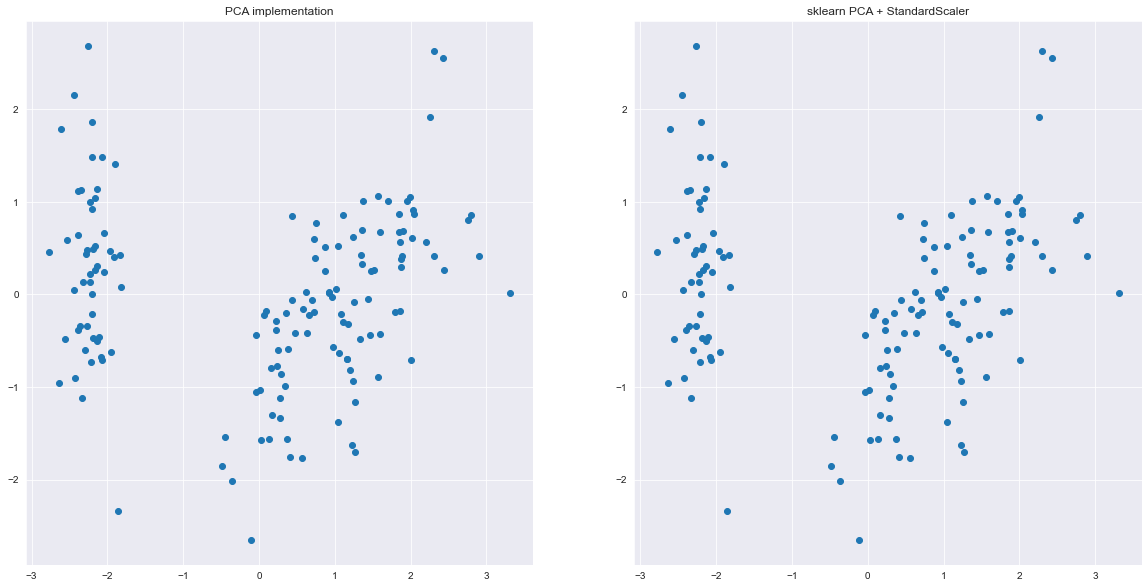

In [5]:
from sklearn.decomposition import PCA as PCA_sklearn

std_scaler = StandardScaler()
X_std = std_scaler.fit_transform(X)
pca_sklearn = PCA_sklearn(n_components=2)
pca_sklearn.fit(X_std)
X_pca_sklearn = pca_sklearn.transform(X_std)

fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(121)
ax1.scatter(X_pca[:, 0], X_pca[:, 1])
ax1.set_title('PCA implementation')
ax2 = fig.add_subplot(122)
ax2.scatter(X_pca_sklearn[:, 0], X_pca_sklearn[:, 1])
ax2.set_title('sklearn PCA + StandardScaler')
plt.show()

When data is standardized, the results are the same.

## Task 2. CIFAR basis (4 points)

Retrieve the data of the CIFAR-10 dataset. Those images has the same shape, making them appropriate for the use of PCA. Your task is to find the most effective basis for the images using PCA you implemented.

In [6]:
from sklearn.datasets import fetch_openml

X, y = fetch_openml('CIFAR_10', version=1, return_X_y=True)

In [14]:
X.shape

(60000, 3072)

In [15]:
def get_image(X, index, clip=True):
    img = np.zeros((32, 32, 3))
    img[:, :, 0] = X[index, :1024].reshape(32, 32)
    img[:, :, 1] = X[index, 1024:2048].reshape(32, 32)
    img[:, :, 2] = X[index, 2048:].reshape(32, 32)
    if clip:
        img[img < 0] = 0
        img[img > 255] = 255
    return img.astype(np.uint8)

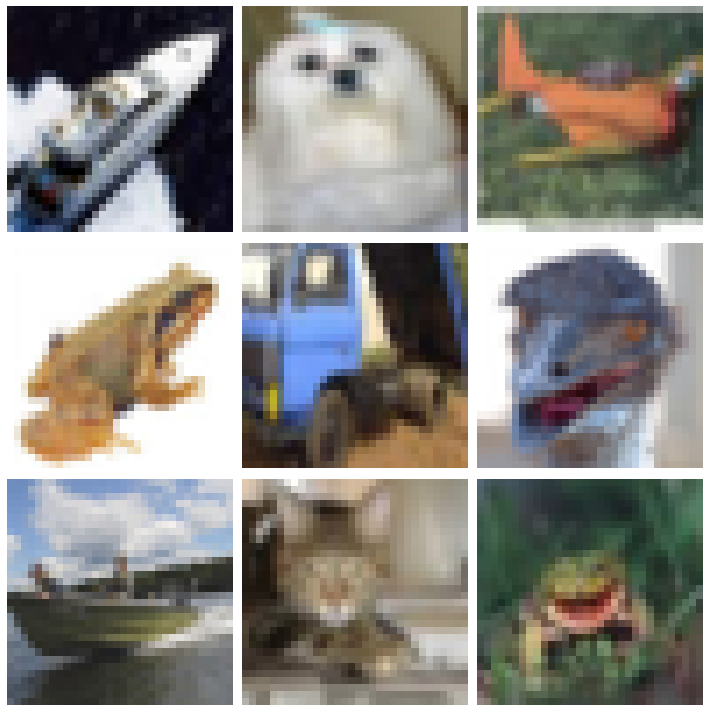

In [16]:
fig = plt.figure(figsize=(10, 10), tight_layout=True)
for i in range(3*3):
    ax = fig.add_subplot(3, 3, i+1)
    ax.imshow(get_image(X, i))
    ax.axis('off')
plt.show()

Create function for image approximation visualization using first `N` basis-"images".

In [17]:
pca = PCA(n_components=50)
pca.fit(X)

In [22]:
def get_img_approximation(img, n_components, clip=True):
    pca.set_n_components(n_components)
    img_pca = pca.transform(np.array([img]))
    img_approx = pca.inverse_transform(img_pca)
    return get_image(img_approx, 0, clip=clip)

(0.0, 1.0, 0.0, 1.0)

C:\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


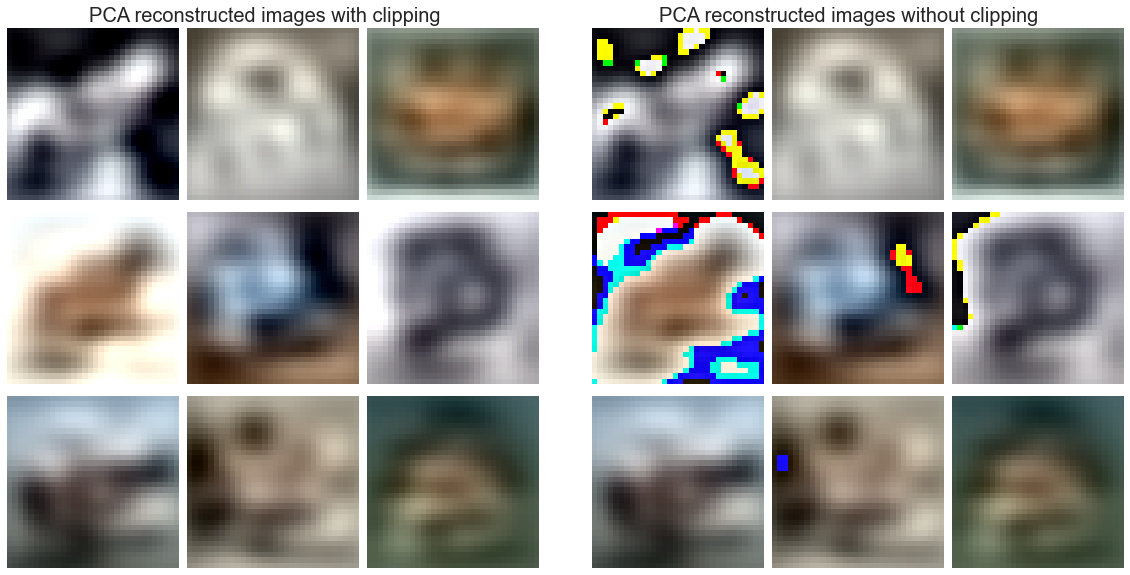

In [25]:
import matplotlib.gridspec as gridspec

n_basis = 50
fig = plt.figure(figsize=(20, 10), tight_layout=True)
outer = gridspec.GridSpec(nrows=1, ncols=2, wspace=0.1)

axs = [[], []]
for col in range(2):
    inner = gridspec.GridSpecFromSubplotSpec(nrows=3, ncols=3, subplot_spec=outer[col], wspace=0.05, hspace=0.05)
    axs[col] = [plt.subplot(cell) for cell in inner]

for i in range(3*3):
    ax = axs[0][i]
    ax.imshow(get_img_approximation(X[i], n_basis, clip=True))
    ax.axis('off')

for i in range(3*3):
    ax = axs[1][i]
    ax.imshow(get_img_approximation(X[i], n_basis, clip=False))
    ax.axis('off')

ax_left = fig.add_axes(axs[0][0].get_position().bounds * np.array([1, 1, 3, 1]))
ax_left.set_title('PCA reconstructed images with clipping', fontsize=20)
ax_left.axis('off')
ax_right = fig.add_axes(axs[1][0].get_position().bounds * np.array([1, 1, 3, 1]))
ax_right.set_title('PCA reconstructed images without clipping', fontsize=20)
ax_right.axis('off')

Create function to visualize `N`-th basis image.

In [27]:
def get_basis(n_components, n, clip=True, brightness=0):
    pca.set_n_components(n_components)
    return get_image(pca.projection_matrix.T * 255 + brightness, n, clip=clip)

(0.0, 1.0, 0.0, 1.0)

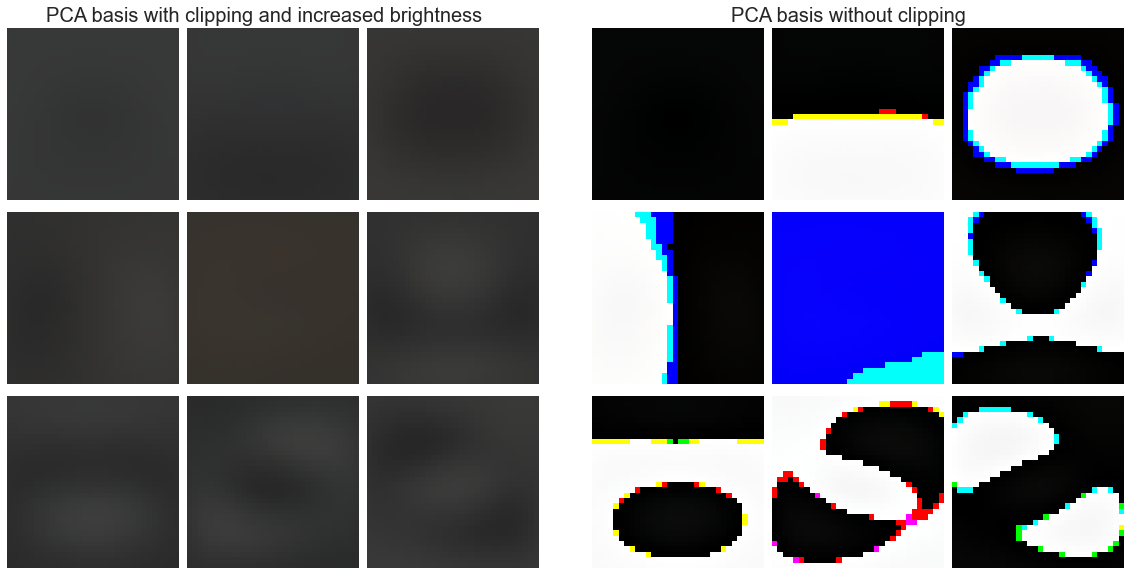

In [28]:
import matplotlib.gridspec as gridspec

n_basis = 50
fig = plt.figure(figsize=(20, 10), tight_layout=True)
outer = gridspec.GridSpec(nrows=1, ncols=2, wspace=0.1)

axs = [[], []]
for col in range(2):
    inner = gridspec.GridSpecFromSubplotSpec(nrows=3, ncols=3, subplot_spec=outer[col], wspace=0.05, hspace=0.05)
    axs[col] = [plt.subplot(cell) for cell in inner]

for i in range(3*3):
    ax = axs[0][i]
    ax.imshow(get_basis(n_basis, i, clip=True, brightness=50))
    ax.axis('off')

for i in range(3*3):
    ax = axs[1][i]
    ax.imshow(get_basis(n_basis, i, clip=False))
    ax.axis('off')

ax_left = fig.add_axes(axs[0][0].get_position().bounds * np.array([1, 1, 3, 1]))
ax_left.set_title('PCA basis with clipping and increased brightness', fontsize=20)
ax_left.axis('off')
ax_right = fig.add_axes(axs[1][0].get_position().bounds * np.array([1, 1, 3, 1]))
ax_right.set_title('PCA basis without clipping', fontsize=20)
ax_right.axis('off')

Train a linear classifier model at image dataset, using logspace-distributed points as the number of components (min – 1, max – all). Use at least 20 distinct numbers of components.

For each trained model, evaluate the model using test set. Plot the dependency of accuracy at test depending on the number of components used by PCA. Explain this dependency.

In [232]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pca = PCA(n_components=X.shape[1])
pca.fit(X_train)

In [239]:
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm

log_space = np.logspace(0, np.log10(X.shape[1]), 50, dtype=int)
accuracy = []
for n_components in tqdm(log_space):
    pca.set_n_components(n_components)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    # train model
    regression = LogisticRegression(max_iter=1000)
    regression.fit(X_train_pca, y_train)
    # evaluate model
    score = regression.score(X_test_pca, y_test)
    accuracy.append((n_components, score))

 86%|████████▌ | 43/50 [06:38<05:56, 50.95s/it]C:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 88%|████████▊ | 44/50 [08:43<07:19, 73.17s/it]C:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

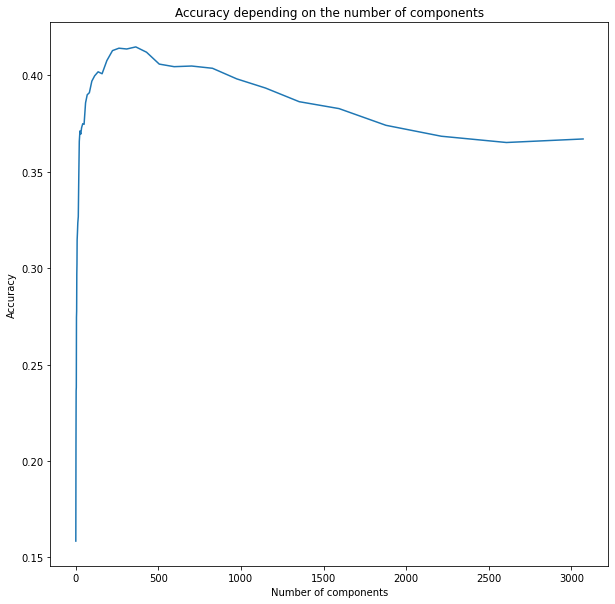

In [241]:
plt.figure(figsize=(10, 10))
plt.plot(*zip(*accuracy))
plt.xlabel('Number of components')
plt.ylabel('Accuracy')
plt.title('Accuracy depending on the number of components')
plt.show()

Plot of dependency of explained variance from the number of components.

Explanation of dependency of accuracy from the number of components:
As the number of components increases, the accuracy increases. This is because the more components we use, the more valuable information (variance) we retain from the original data. However, the accuracy does not increase indefinitely, but reaches a certain limit and even starts decreasing afterwards. This is because PCA can start to capture noise, specific to training data (overfitting). Moreover, the more complex the feature space, the less informative distance between points becomes, which makes it harder to separate classes (curse of dimensionality).

As you may notice, many basis images have negative elements, although the data itself is purely non-negative. Why is it so, why do we have negative elements from mathematical point of view? In what cases negative elements may be absent in PCA projection vectors?

First of all, eigenvectors are defined up to a sign, so if a vector is non-negative we can always flip the sign of the vector to make it non-positive (or vice versa): If $v$ is an eigenvector, then $Av = \lambda v$, where $\lambda$ is an eigenvalue. Then $A(-v) = -Av = -\lambda v$ = $\lambda (-v)$, so $-v$ is also an eigenvector.

Negative elements may be absent in PCA projection vectors in case, when we can construct diagonal matrix out of them (converse is also true, since we can flip the sign of any vector, that is non-positive). This is because, for any set of non-negative orthogonal vectors, if some element $u_i$ in one this vectors is non-zero, then the elements with the same index $v_i$ in all other vectors must be zero. (Proof is below).

Let $P$ be a set of orthogonal vectors. We aim to prove that if there exists a pair of vectors $u, v \in P$ such that $\exists i \in \{1, \ldots, n\}: u_i \cdot v_i \neq 0$, then either $u$ or $v$ must have at least one negative element.

Assume, for the sake of contradiction, that both $u$ and $v$ are non-negative vectors, i.e., $\forall i \in \{1, \ldots, n\}: u_i \geq 0$ and $\forall i \in \{1, \ldots, n\}: v_i \geq 0$.

Since $u$ and $v$ are orthogonal vectors, their dot product is given by: $u^T v = \sum_{i=1}^n u_i v_i = 0.$

Now, consider the term $u_i \cdot v_i$ in this sum. Since $\forall i \in \{1, \ldots, n\}: u_i \geq 0$ and $\forall i \in \{1, \ldots, n\}: v_i \geq 0$, their product $u_i \cdot v_i$ is also non-negative. More over, any other non-zero term in the sum $u^T v$ is also non-negative. Hence, the sum $u^T v$ is non-negative. However, we know that $u^T v = 0$. This is a contradiction.

Hence, our assumption that both $u$ and $v$ are non-negative vectors must be false. At least one element in either vector $u$ or vector $v$ must be negative, which concludes the proof.


---

There are matrix decompositions, that may be more useful than SVD in particular cases. For example, non-negative matrix factorization. You should implement [it](https://en.wikipedia.org/wiki/Non-negative_matrix_factorization#Algorithms) and use at the CIFAR-10 dataset.

In [29]:
from tqdm import tqdm

class NNMF:
    def __init__(self, n_components):
        self.n_components = n_components
        self.w = None
        self.h = None
        self.X = None
        self.loss_epoch = []

    def update_H(self, W, H, V):
        numerator = W.T.dot(V)
        denominator = W.T.dot(W).dot(H) + 1e-10
        H = H*(numerator / denominator)
        return H

    def update_W(self, W, H, V):
        numerator = V.dot(H.T)
        denominator = W.dot(H).dot(H.T) + 1e-10
        W = W*(numerator / denominator)
        return W

    def fit(self, X, y=None, compute_error=False, n_iter=10, verbose=True):
        W = np.abs(np.random.randn(1, X.shape[0], self.n_components))[0]
        H = np.abs(np.random.randn(1, self.n_components, X.shape[1]))[0]

        e = 1e-10
        for epoch in tqdm(range(n_iter), total=n_iter, disable=not verbose):
            H = self.update_H(W, H, X)
            W = self.update_W(W, H, X)
            self.w = W
            self.h = H
            if compute_error:
                error = np.linalg.norm(X - W.dot(H))
                self.loss_epoch.append(error)

        return W, H

    def transform(self, X, y=None, n_iter=10, verbose=True):
        W = self.w
        H = np.abs(np.random.randn(1, self.n_components, X.shape[1]))[0]
        for epoch in tqdm(range(n_iter), total=n_iter, disable=not verbose):
            H = self.update_H(W, H, X)
        return W, H

    def inverse_transform(self, W, y=None):
        return W.dot(self.h)

In [30]:
nnmf = NNMF(n_components=50)
W, H = nnmf.fit(X.T, compute_error=True, n_iter=300)

100%|██████████| 300/300 [11:08<00:00,  2.23s/it]


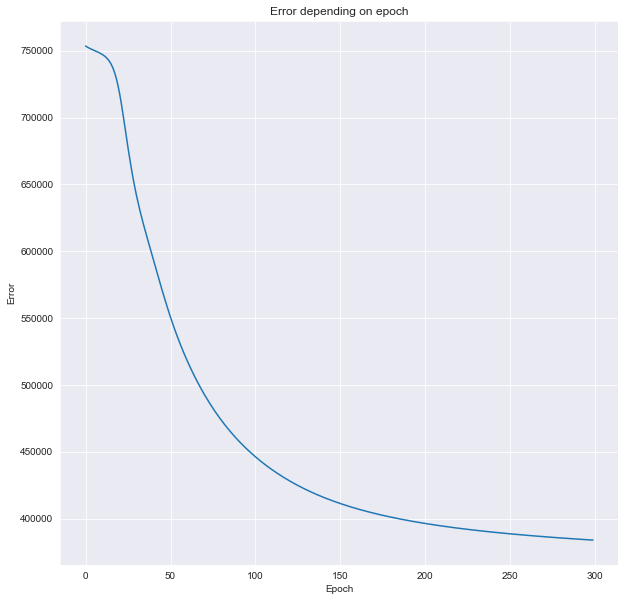

In [31]:
fig = plt.figure(figsize=(10, 10))
plt.plot(nnmf.loss_epoch)
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Error depending on epoch')
plt.show()

Frobenuis norm of the difference between original matrix and its approximation ($||V - WH||_F$):

In [32]:
nnmf.loss_epoch[-1]

384037.8289103267

Do not forget to check, that $W H = V$.  
Which of those matrices contains basis images? Why do you think so? What is inside the other matrix?

Answer: In the case, when V is $n \times m$ image dataset, in which each column contains n non-negative pixel values of one of the m images, $W$ contains basis images, because it is multiplied by $H$ to get $V$ and has dimensions $n \times k$, where $k$ is the number of basis images and $n$ is the number of features, hence each column of $W$ contains 32x32x3 image. $H$ contains coefficients, that are used to multiply each basis image to get the original image. It has dimensions $k \times m$, where $m$ is the number of images in the dataset.

Compare first five basis images created by PCA and by NNMF. Write down your observations.

In [34]:
nnmf.w.shape, nnmf.h.shape

((3072, 50), (50, 60000))

In [35]:
def get_basis_nnmf(brightness=0):
    return nnmf.w.T * 255 + brightness

(0.0, 1.0, 0.0, 1.0)

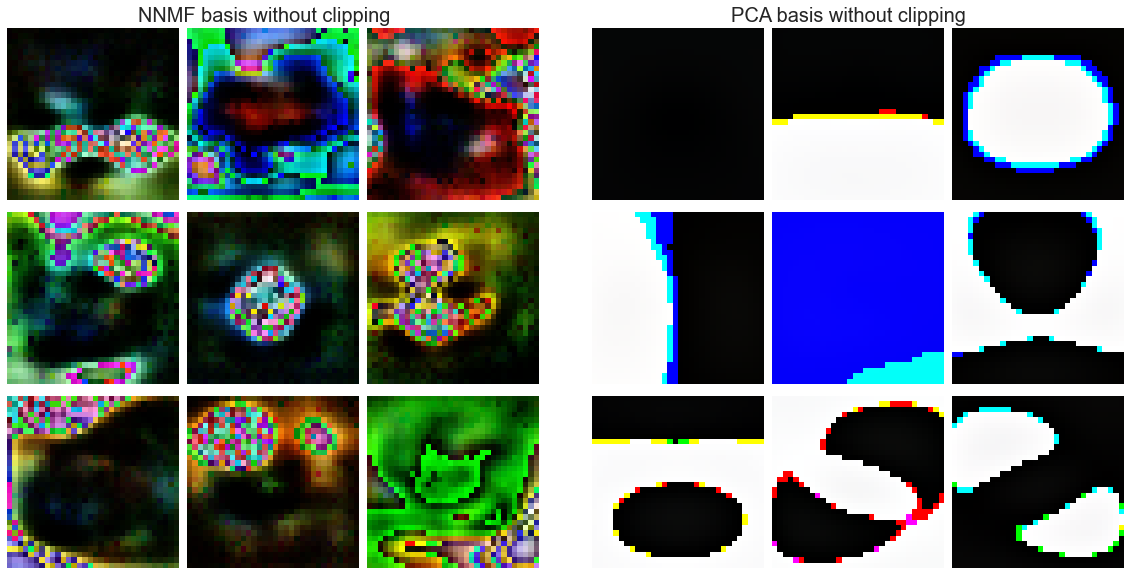

In [36]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(20, 10), tight_layout=True)
outer = gridspec.GridSpec(nrows=1, ncols=2, wspace=0.1)

axs = [[], []]
for col in range(2):
    inner = gridspec.GridSpecFromSubplotSpec(nrows=3, ncols=3, subplot_spec=outer[col], wspace=0.05, hspace=0.05)
    axs[col] = [plt.subplot(cell) for cell in inner]

basis = get_basis_nnmf()
for i in range(3*3):
    ax = axs[0][i]
    ax.imshow(get_image(basis, i, clip=False))
    ax.axis('off')

for i in range(3*3):
    ax = axs[1][i]
    ax.imshow(get_basis(n_basis, i, clip=False))
    ax.axis('off')

ax_left = fig.add_axes(axs[0][0].get_position().bounds * np.array([1, 1, 3, 1]))
ax_left.set_title('NNMF basis without clipping', fontsize=20)
ax_left.axis('off')
ax_right = fig.add_axes(axs[1][0].get_position().bounds * np.array([1, 1, 3, 1]))
ax_right.set_title('PCA basis without clipping', fontsize=20)
ax_right.axis('off')

(0.0, 1.0, 0.0, 1.0)

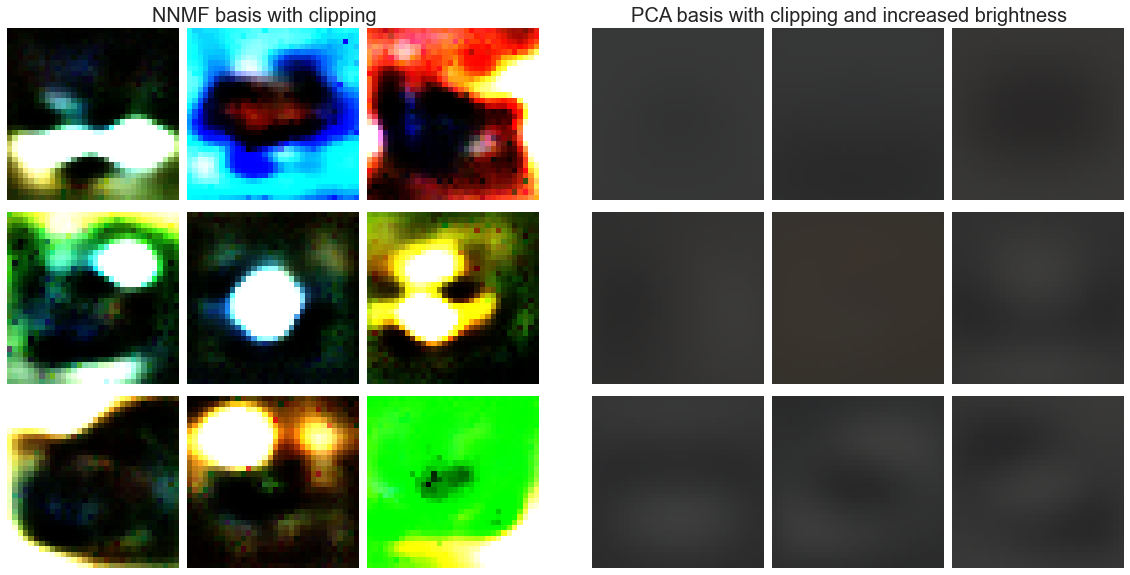

In [37]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(20, 10), tight_layout=True)
outer = gridspec.GridSpec(nrows=1, ncols=2, wspace=0.1)

axs = [[], []]
for col in range(2):
    inner = gridspec.GridSpecFromSubplotSpec(nrows=3, ncols=3, subplot_spec=outer[col], wspace=0.05, hspace=0.05)
    axs[col] = [plt.subplot(cell) for cell in inner]

basis = get_basis_nnmf()
for i in range(3*3):
    ax = axs[0][i]
    ax.imshow(get_image(basis, i, clip=True))
    ax.axis('off')

for i in range(3*3):
    ax = axs[1][i]
    ax.imshow(get_basis(n_basis, i, clip=True, brightness=50))
    ax.axis('off')

ax_left = fig.add_axes(axs[0][0].get_position().bounds * np.array([1, 1, 3, 1]))
ax_left.set_title('NNMF basis with clipping', fontsize=20)
ax_left.axis('off')
ax_right = fig.add_axes(axs[1][0].get_position().bounds * np.array([1, 1, 3, 1]))
ax_right.set_title('PCA basis with clipping and increased brightness', fontsize=20)
ax_right.axis('off')

Answer: First of all, it is clear that NNMF basis images are non-negative, while PCA basis images are not. Also, PCA captures global structures in the data, for example, edges. NNMF, on the other hand, produces basis images and coefficients that represent additive parts and tend to capture local structures in the data, like color patches.

Randomly choose some images, re-create them using PCA and NNMF. How do the resulting images differ? Write down your observations.

(0.0, 1.0, 0.0, 1.0)

C:\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


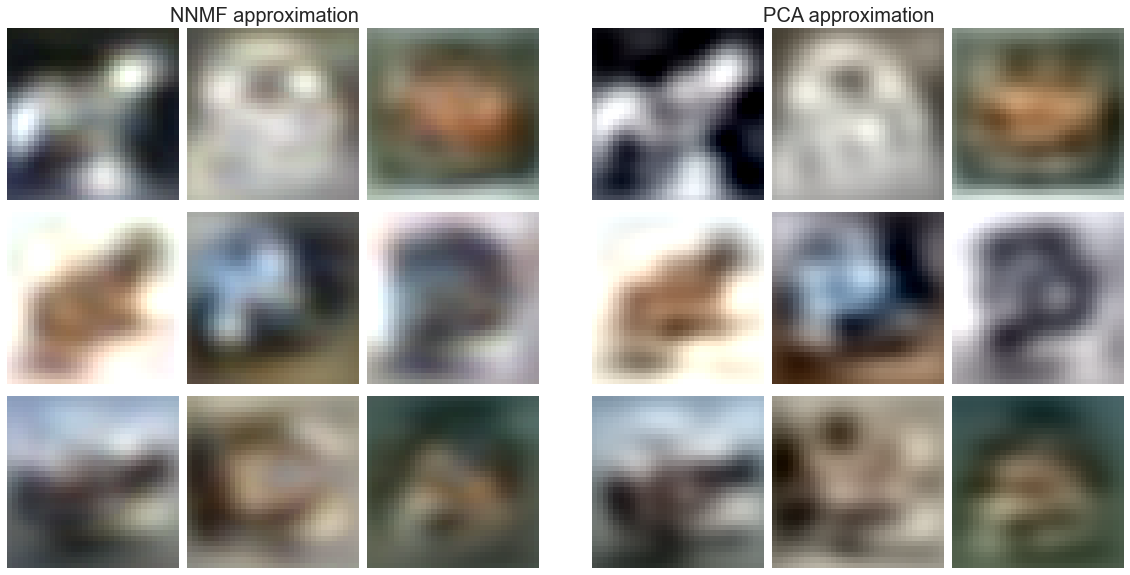

In [38]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(20, 10), tight_layout=True)
outer = gridspec.GridSpec(nrows=1, ncols=2, wspace=0.1)

axs = [[], []]
for col in range(2):
    inner = gridspec.GridSpecFromSubplotSpec(nrows=3, ncols=3, subplot_spec=outer[col], wspace=0.05, hspace=0.05)
    axs[col] = [plt.subplot(cell) for cell in inner]

X_approx = W.dot(H).T
for i in range(3*3):
    ax = axs[0][i]
    ax.imshow(get_image(X_approx, i))
    ax.axis('off')

n_basis = 50
for i in range(3*3):
    ax = axs[1][i]
    ax.imshow(get_img_approximation(X[i], n_basis))
    ax.axis('off')

ax_left = fig.add_axes(axs[0][0].get_position().bounds * np.array([1, 1, 3, 1]))
ax_left.set_title('NNMF approximation', fontsize=20)
ax_left.axis('off')
ax_right = fig.add_axes(axs[1][0].get_position().bounds * np.array([1, 1, 3, 1]))
ax_right.set_title('PCA approximation', fontsize=20)
ax_right.axis('off')

Images produced by PCA has more quality and are more distinguishable, then images produced by NNMF, which are more blurry. However, this can change with the increase of number of iterations of MU algorithm for computing NNMF.

Train a linear classifier model at image dataset, using logspace-distributed points as the number of non-negative components (min – 1, max – all). Use at least 20 distinct numbers of components.

For each trained model, evaluate the model using test set. Plot the dependency of accuracy at test depending on the number of components used by NNMF. Explain this dependency. Compare and contrast the dependency to one retrieved by PCA.

In [179]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [207]:
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm

log_space = np.logspace(0, np.log10(X.shape[1]), 20, dtype=int)
accuracy_nnmf = []
for n_components in tqdm(log_space, total=len(log_space), desc='Train'):
    nmf = NNMF(n_components=n_components)
    W, H = nmf.fit(X_train.T, n_iter=50, compute_error=False, verbose=False)
    X_train_nmf = W.dot(H).T
    X_test_nmf = W.dot(nmf.transform(X_test.T, n_iter=50, verbose=False)[1]).T
    # train model
    regression = LogisticRegression(max_iter=1000)
    regression.fit(X_train_nmf, y_train)
    # evaluate model
    score = regression.score(X_test_nmf, y_test)
    accuracy_nnmf.append((n_components, score))
    print(f'Accuracy for {n_components} components: {score}')

Train:   5%|▌         | 1/20 [00:24<07:49, 24.73s/it]

Accuracy for 1 components: 0.09941666666666667


Train:  10%|█         | 2/20 [00:50<07:31, 25.11s/it]

Accuracy for 1 components: 0.09941666666666667


Train:  15%|█▌        | 3/20 [01:22<08:05, 28.54s/it]

Accuracy for 2 components: 0.17141666666666666


Train:  20%|██        | 4/20 [02:02<08:47, 32.99s/it]

Accuracy for 3 components: 0.19033333333333333


Train:  25%|██▌       | 5/20 [03:16<11:55, 47.73s/it]

Accuracy for 5 components: 0.19933333333333333


Train:  30%|███       | 6/20 [04:46<14:30, 62.15s/it]

Accuracy for 8 components: 0.26658333333333334


Train:  35%|███▌      | 7/20 [06:42<17:17, 79.82s/it]

Accuracy for 12 components: 0.27425


Train:  40%|████      | 8/20 [09:16<20:41, 103.47s/it]

Accuracy for 19 components: 0.298


Train:  45%|████▌     | 9/20 [12:19<23:30, 128.23s/it]

Accuracy for 29 components: 0.3135


Train:  50%|█████     | 10/20 [15:55<25:54, 155.46s/it]

Accuracy for 44 components: 0.32958333333333334


Train:  55%|█████▌    | 11/20 [21:08<30:30, 203.44s/it]

Accuracy for 68 components: 0.3398333333333333


C:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
Train:  60%|██████    | 12/20 [26:51<32:47, 245.94s/it]

Accuracy for 104 components: 0.3511666666666667


C:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
Train:  65%|██████▌   | 13/20 [32:46<32:33, 279.02s/it]

Accuracy for 159 components: 0.3571666666666667


C:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
Train:  70%|███████   | 14/20 [38:59<30:44, 307.33s/it]

Accuracy for 243 components: 0.3739166666666667


C:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
Train:  75%|███████▌  | 15/20 [45:39<27:56, 335.33s/it]

Accuracy for 371 components: 0.3824166666666667


C:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
Train:  80%|████████  | 16/20 [53:05<24:35, 368.78s/it]

Accuracy for 566 components: 0.3855


C:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
Train:  85%|████████▌ | 17/20 [1:01:30<20:28, 409.55s/it]

Accuracy for 864 components: 0.3895


C:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
Train:  90%|█████████ | 18/20 [1:11:43<15:41, 470.83s/it]

Accuracy for 1319 components: 0.392


C:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
Train:  95%|█████████▌| 19/20 [1:24:50<09:25, 565.66s/it]

Accuracy for 2013 components: 0.39866666666666667


C:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
Train: 100%|██████████| 20/20 [1:42:21<00:00, 307.08s/it]

Accuracy for 3071 components: 0.39158333333333334


In [177]:
accuracy_pca = accuracy

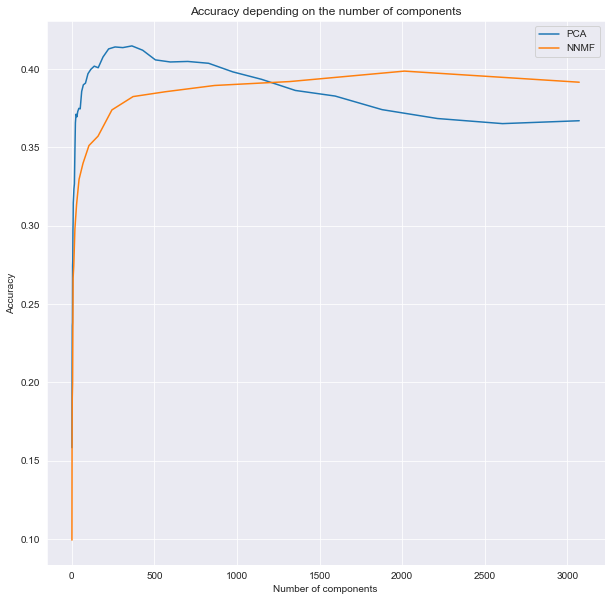

In [208]:
plt.figure(figsize=(10, 10))
plt.plot(*zip(*accuracy_pca), label='PCA')
plt.plot(*zip(*accuracy_nnmf), label='NNMF')
plt.xlabel('Number of components')
plt.ylabel('Accuracy')
plt.title('Accuracy depending on the number of components')
plt.legend()
plt.show()

Answer: NNMF accuracy increases for longer as number of components increases, but it does never reach the maximum accuracy of PCA. However, this may be due to low iterations number (50) for NNMF MU algorithm.